In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import struct, zlib
import math

def read_frames(input_folder: str, limit: int = None) -> np.ndarray:
    
    folder = Path(input_folder)
    frames = []

    for file in sorted(folder.glob("*.*")):
        if limit is not None and len(frames) >= limit:
            break

        if file.suffix.lower() not in {".png", ".jpg", ".jpeg"}:
            continue

        img = plt.imread(file)

        if img.ndim == 3:
            img = (0.2989 * img[..., 0] +
                   0.5870 * img[..., 1] +
                   0.1140 * img[..., 2])

        if img.dtype != np.uint8:
            img = (img * 255).astype(np.uint8)

        frames.append(img)

    return np.stack(frames)
 

In [5]:
input_folder3 = r"C:\Users\user\Downloads\Augmented_person"
input_folder1 = r"C:\Users\user\Downloads\person1"

frames1 = read_frames(input_folder1)
frames3 = read_frames(input_folder3)
print("Frames array shape:", frames1.shape)   
print("Pixel values of first frame:\n", frames1[0][:5,:5])

Frames array shape: (467, 720, 1280)
Pixel values of first frame:
 [[ 60  58  47  35  28]
 [ 45  51  47  46  42]
 [ 45  43  39  34  34]
 [ 61  55  55  57  71]
 [ 38  42  50  82 101]]


In [29]:
import struct, zlib
import numpy as np

def make_chunk(chunk_type: bytes, data: bytes) -> bytes:
    length = struct.pack("!I", len(data))
    crc    = struct.pack("!I", zlib.crc32(chunk_type + data) & 0xffffffff)
    return length + chunk_type + data + crc

def write_png(img: np.ndarray, filename: str) -> None:
    
    h, w = img.shape
    sig  = b'\x89PNG\r\n\x1a\n'
    ihdr = make_chunk(b'IHDR',
                      struct.pack("!IIBBBBB", w, h, 8, 0, 0, 0, 0))
    raw  = b''.join(b'\x00' + img[y].tobytes() for y in range(h))
    idat = make_chunk(b'IDAT', zlib.compress(raw))
    iend = make_chunk(b'IEND', b'')
    png_bytes = sig + ihdr + idat + iend

    with open(filename, 'wb') as f:
        f.write(png_bytes)
    


In [30]:
def plot_frames(frames: list, num_frames: int, save_name: str) -> None:
    
    num_frames = min(num_frames, len(frames))

    cols = 5  
    rows = math.ceil(num_frames / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))

    axes = axes.ravel()

    for i in range(num_frames):
        axes[i].imshow(frames[i], cmap='gray')
        axes[i].set_title(f"Frame {i}")
        axes[i].axis("off")

    for j in range(num_frames, rows * cols):
        axes[j].axis("off")

    plt.tight_layout()
    plt.savefig(save_name, format="pdf")
    plt.close()

In [31]:
frames = read_frames(input_folder1, limit=10)  
plot_frames(frames, num_frames=10, save_name="report.pdf")


In [9]:
def compute_mean(frames: np.ndarray) -> np.ndarray:
    F, H, W = frames.shape
    mean = np.zeros((H, W), dtype=float)

    for i in range(H):
        for j in range(W):
            sum_val = 0.0
            for f in range(F):
                sum_val += frames[f, i, j]
            mean[i, j] = sum_val / F
    return mean

In [10]:
def compute_variance(frames: np.ndarray, mean: np.ndarray) -> np.ndarray:
    F, H, W = frames.shape
    var = np.zeros((H, W), dtype=float)

    for i in range(H):
        for j in range(W):
            s = 0.0
            for f in range(F):
                diff = frames[f, i, j] - mean[i, j]
                s += diff * diff
            var[i, j] = s / F
    return var

def norm_var(variance): 
    norm_v = (variance - variance.min()) / (variance.max() - variance.min())
    norm_v = (norm_v * 255).astype(np.uint8)
    return norm_v

In [11]:
def build_background_model(frames: np.ndarray, t: int) -> tuple:
    
    fra = frames[:t]
    mean_frame = compute_mean(fra)
    variance_frame = compute_variance(fra, mean_frame)
    return mean_frame, variance_frame

In [12]:
from matplotlib.backends.backend_pdf import PdfPages

def compute_mask(frame: np.ndarray, mean_frame: np.ndarray, variance_frame: np.ndarray, threshold: float = 5.0) -> np.ndarray:
    
    eps = 1e-6 # handle 0 variance
    mahalanobis = ((frame - mean_frame) ** 2) / (variance_frame + eps)
    mask = (mahalanobis > threshold).astype(np.uint8)
    return mask

def save_masks_to_pdf(frames, mean_frame, var_frame, thresholds, start_idx, end_idx, step, pdf_name):
    
    with PdfPages(pdf_name) as pdf:
        for f_idx in range(start_idx, end_idx+1, step):
            frame = frames[f_idx]

            fig, axes = plt.subplots(1, len(thresholds)+1, figsize=(4*(len(thresholds)+1), 4))

            axes[0].imshow(frame, cmap="gray")
            axes[0].set_title(f"Original (frame {f_idx})")
            axes[0].axis("off")

            
            for j, thr in enumerate(thresholds):
                mask = compute_mask(frame, mean_frame, var_frame, threshold=thr)
                axes[j+1].imshow(mask, cmap="gray")
                axes[j+1].set_title(f"thr={thr}")
                axes[j+1].axis("off")

            plt.tight_layout()
            pdf.savefig(fig)   
            plt.close(fig)

    print(f" Saved PDF report: {pdf_name}")

In [32]:
p1m ,p1v = build_background_model(frames1,70)
write_png(p1m.astype(np.uint8), "p1mean.png")
p1v_norm = norm_var(p1v)
write_png(p1v_norm, "p1variance.png")
p3m, p3v = build_background_model(frames3, 60)
write_png(p3m.astype(np.uint8), "p3mean.png")
p3v_norm = norm_var(p3v)
write_png(p3v_norm, "p3variance.png")
#thresholds = [2.0, 5.0, 8.0]
#save_masks_to_pdf(frames1, p1m, p1v, thresholds, start_idx=84, end_idx=94, step=1, pdf_name="report_mask_person1.pdf")
#save_masks_to_pdf(frames3, p3m, p3v , thresholds, start_idx=85, end_idx=95, step=1, pdf_name="report_mask_person3.pdf")

In [33]:
def generate_and_save_masks(frames, mean_img, var_img, threshold, save_path):
    
    frames = frames.astype(np.float32)
    mean_img = mean_img.astype(np.float32)
    var_img = var_img.astype(np.float32)

    F, H, W = frames.shape
    masks = np.zeros((F, H, W), dtype=np.uint8)

    for i in range(F):
        frame = frames[i]
        mask = compute_mask(frame, mean_img, var_img, threshold)
        masks[i] = mask

    np.save(save_path, masks)
    print(f"Saved {F} masks -> {save_path} | Shape: {masks.shape}")
    return masks



In [15]:
def create_kernel(kernel_size=3):
    return np.ones((kernel_size, kernel_size), dtype=np.uint8)


def erode(mask: np.ndarray, kernel: np.ndarray, anchor: tuple = None, iterations: int = 1) -> np.ndarray:
    
    img = (mask > 0).astype(np.uint8) * 255
    kh, kw = kernel.shape

    if anchor is None:
        ay = kh // 2
        ax = kw // 2
    else:
        ay, ax = anchor

    pad_top = ay
    pad_bottom = kh - 1 - ay
    pad_left = ax
    pad_right = kw - 1 - ax

    H, W = img.shape

    for _ in range(iterations):
        padded = np.pad(img, ((pad_top, pad_bottom), (pad_left, pad_right)),
                        mode="constant", constant_values=0)
        out = np.zeros_like(img, dtype=np.uint8)

        for i in range(H):
            for j in range(W):
                top = i
                left = j
                region = padded[top: top + kh, left: left + kw]
                
                if np.all(region[kernel == 1] == 255):
                    out[i, j] = 255
                
        img = out  

    return img


def dilate(mask: np.ndarray, kernel: np.ndarray, anchor: tuple = None, iterations: int = 1) -> np.ndarray:
    
    img = (mask > 0).astype(np.uint8) * 255
    kh, kw = kernel.shape

    if anchor is None:
        ay = kh // 2
        ax = kw // 2
    else:
        ay, ax = anchor

    pad_top = ay
    pad_bottom = kh - 1 - ay
    pad_left = ax
    pad_right = kw - 1 - ax

    H, W = img.shape

    for _ in range(iterations):
        padded = np.pad(img, ((pad_top, pad_bottom), (pad_left, pad_right)),
                        mode="constant", constant_values=0)
        out = np.zeros_like(img, dtype=np.uint8)

        for i in range(H):
            for j in range(W):
                top = i
                left = j
                region = padded[top: top + kh, left: left + kw]
                if np.any(region[kernel == 1] == 255):
                    out[i, j] = 255
        img = out

    return img


def morphological_operations(mask: np.ndarray, kernel_size: int = 3) -> np.ndarray:
    
    kernel = create_kernel(kernel_size)
    
    anchor = (kernel_size // 2, kernel_size // 2)

    eroded = erode(mask, kernel, anchor=anchor, iterations=1)
    cleaned = dilate(eroded, kernel, anchor=anchor, iterations=1)
    return cleaned


In [34]:
best_thr = 2.0

masks_p1 = generate_and_save_masks(frames1, p1m, p1v,threshold=best_thr, save_path="person1_masks.npy")
#save_morphology_pdf(masks_p1, kernel_sizes=[3, 5, 7, 11],frame_range=range(78, 82), pdf_file="morphology_tests_p1.pdf")


masks_p3 = generate_and_save_masks(frames3, p3m, p3v,threshold=best_thr, save_path="person3_masks.npy")
#save_morphology_pdf(masks_p3, kernel_sizes=[3, 5, 7, 11],frame_range=range(88, 92), pdf_file="morphology_tests_p3.pdf")


Saved 467 masks -> person1_masks.npy | Shape: (467, 720, 1280)
Saved 260 masks -> person3_masks.npy | Shape: (260, 360, 640)


In [36]:
from collections import deque

def find_connected_components(mask: np.ndarray, connectivity: int = 8):
    
    H, W = mask.shape
    labeled = np.zeros((H, W), dtype=np.int32)
    visited = np.zeros_like(mask, dtype=bool)

    if connectivity == 4:
        offsets = [(-1,0),(1,0),(0,-1),(0,1)]
    else:  
        offsets = [(-1,0),(1,0),(0,-1),(0,1),
                   (-1,-1),(-1,1),(1,-1),(1,1)]

    comp_info = []
    label = 0

    for r in range(H):
        for c in range(W):
            if mask[r, c] == 0 or visited[r, c]:
                continue

            label += 1
            q = deque([(r, c)])
            visited[r, c] = True
            pixels = []

            while q:
                y, x = q.popleft()
                labeled[y, x] = label
                pixels.append((y, x))

                for dy, dx in offsets:
                    ny, nx = y + dy, x + dx
                    if 0 <= ny < H and 0 <= nx < W:
                        if mask[ny, nx] != 0 and not visited[ny, nx]:
                            visited[ny, nx] = True
                            q.append((ny, nx))

            ys = np.array([p[0] for p in pixels])
            xs = np.array([p[1] for p in pixels])
            vals = mask[ys, xs]

            area = len(pixels)
            avg  = float(vals.mean())
            centroid = (float(ys.mean()), float(xs.mean()))
            bbox = (int(ys.min()), int(xs.min()),
                    int(ys.max()), int(xs.max()))

            comp_info.append({
                'label'   : label,
                'area'    : area,
                'avg'     : avg,
                'centroid': centroid,
                'bbox'    : bbox
            })

    return label, labeled, comp_info


Connected components found: 6
Label 1: Area=9056  Centroid=(121.39818904593639, 162.605675795053)  BBox=(43, 116, 199, 211)
Label 2: Area=233  Centroid=(194.57510729613733, 175.60085836909872)  BBox=(187, 167, 206, 188)
Label 3: Area=205  Centroid=(208.87317073170732, 158.26341463414633)  BBox=(198, 149, 217, 170)
Label 4: Area=838  Centroid=(249.41527446300717, 156.19928400954655)  BBox=(223, 145, 273, 170)
Label 5: Area=16  Centroid=(227.5, 174.5)  BBox=(226, 173, 229, 176)
Label 6: Area=14  Centroid=(229.5, 167.5)  BBox=(228, 166, 231, 169)


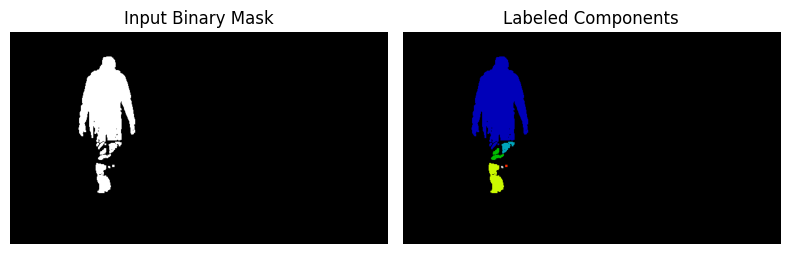

In [40]:
def test_connected_components(any_mask: np.ndarray, connectivity: int = 8):
    
    mask = (any_mask > 0).astype(np.uint8) * 255

    num, labeled, info = find_connected_components(mask, connectivity=connectivity)

    print(f"Connected components found: {num}")
    for comp in info:
        print(f"Label {comp['label']}: "
              f"Area={comp['area']}  "
              f"Centroid={comp['centroid']}  "
              f"BBox={comp['bbox']}")

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
    ax1.imshow(mask, cmap="gray")
    ax1.set_title("Input Binary Mask")
    ax1.axis("off")

    ax2.imshow(labeled, cmap="nipy_spectral")
    ax2.set_title("Labeled Components")
    ax2.axis("off")

    plt.tight_layout()
    plt.show()

single_mask = masks_p3[109]
cleaned1 = morphological_operations(single_mask, 3)

test_connected_components(cleaned1)



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends import backend_pdf
from pathlib import Path

def clean_all_masks(masks: np.ndarray, kernel_size: int = 3) -> np.ndarray:
    
    return np.array(
        [morphological_operations(mask, kernel_size=kernel_size) for mask in masks],
        dtype=np.uint8
    )


def remove_person_alpha_blending(frames_with_person, background_frame, masks):
    
    num_frames = frames_with_person.shape[0]
    new_frames = np.zeros_like(frames_with_person, dtype=np.float32)

    masks = masks.astype(float)

    for i in range(num_frames):
        alpha = min((i + 1) / num_frames, 1.0)

        mask = masks[i]

        alpha_mask = alpha * mask

        new_frame = frames_with_person[i] * (1 - alpha_mask) + background_frame * alpha_mask
        new_frames[i] = new_frame

    return new_frames.astype(np.uint8)


def make_pdf_report(frames_with_person, cleaned_masks, new_frames, out_pdf_path):
    
    with backend_pdf.PdfPages(out_pdf_path) as pdf:
        for orig, mask, new in zip(frames_with_person, cleaned_masks, new_frames):
            fig, axes = plt.subplots(1, 3, figsize=(12, 4))

            axes[0].imshow(orig, cmap="gray")
            axes[0].set_title("Original")
            axes[0].axis("off")

            axes[1].imshow(mask, cmap="gray")
            axes[1].set_title("Cleaned Mask")
            axes[1].axis("off")

            axes[2].imshow(new, cmap="gray")
            axes[2].set_title("Person Removed")
            axes[2].axis("off")

            pdf.savefig(fig)
            plt.close(fig)




In [ ]:

cleaned_masks = clean_all_masks(masks_p3, kernel_size=3)

background = np.mean(frames3[:70], axis=0).astype(np.uint8)

new_frames = remove_person_alpha_blending(frames3, background, cleaned_masks)

pdf_path = Path.home() / "Desktop" / "person_removal_report.pdf"
make_pdf_report(frames3, cleaned_masks, new_frames, pdf_path)

print(f"[OK] PDF saved at: {pdf_path}")


[OK] PDF saved at: C:\Users\user\Desktop\person_removal_report.pdf


In [73]:
import cv2
from pathlib import Path
import numpy as np

def save_alphavideo(frames: np.ndarray,
                          out_dir: str,
                          video_name: str = "alpha_blend_video.mp4",
                          fps: int = 10) -> None:
    
    out_path = Path(out_dir)
    out_path.mkdir(parents=True, exist_ok=True)

    N, H, W = frames.shape

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    writer = cv2.VideoWriter(str(out_path / video_name),
                             fourcc, fps, (W, H), isColor=False)

    for i in range(N):
        writer.write(frames[i])  

    writer.release()
    print(f"[OK] Alpha-blend video saved: {out_path / video_name}")


In [76]:
output_dir = Path.home() / "Desktop"
save_alphavideo(new_frames, out_dir=output_dir, video_name="alpha_blend_video.mp4", fps=10)


[OK] Alpha-blend video saved: C:\Users\user\Desktop\alpha_blend_video.mp4


In [ ]:
def main():
    input_folder = r"C:\Users\user\Downloads\Augmented_person"
    output_folder = Path(r"C:\Users\user\Desktop\Assignment1_Output")
    output_folder.mkdir(parents=True, exist_ok=True)

    frames = read_frames(input_folder)
    print(f"[INFO] Loaded {frames.shape[0]} frames from {input_folder}")

    # ---- 2. Background model (first 70 frames or all if fewer) --------------
    bg_count = min(70, frames.shape[0])
    mean_img, var_img = build_background_model(frames, bg_count)

    # Save mean & variance images
    write_png(mean_img.astype(np.uint8), output_folder / "mean.png")
    norm_v = ( (var_img - var_img.min()) /
               (var_img.max() - var_img.min() + 1e-6) * 255 ).astype(np.uint8)
    write_png(norm_v, output_folder / "variance.png")

    # ---- 3. Foreground masks for all frames ---------------------------------
    best_thr = 2.0
    masks = np.zeros_like(frames, dtype=np.uint8)
    for i, f in enumerate(frames):
        masks[i] = compute_mask(f, mean_img, var_img, threshold=best_thr)

    # Morphological cleaning
    cleaned_masks = np.array([morphological_operations(m) for m in masks], dtype=np.uint8)

    # ---- 4. Person removal via alpha blending -------------------------------
    background = mean_img.astype(np.uint8)
    new_frames = remove_person_alpha_blending(frames, background, cleaned_masks)

    # ---- 5. Save report & video --------------------------------------------
    make_pdf_report(frames, cleaned_masks, new_frames, output_folder / "person_removal_report.pdf")
    save_alphavideo(new_frames, output_folder)

    print(f"[DONE] Results stored in: {output_folder}")




In [78]:
if __name__ == "__main__":
    main()

[INFO] Loaded 260 frames from C:\Users\user\Downloads\Augmented_person
[OK] Alpha-blend video saved: C:\Users\user\Desktop\Assignment1_Output\alpha_blend_video.mp4
[DONE] Results stored in: C:\Users\user\Desktop\Assignment1_Output
